<a href="https://colab.research.google.com/github/Morax19/ML_UCV/blob/main/Tarea2/Tarea2_ML_notebook_parte2/Tarea2_ML_DanielHernandez_Parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TAREA 2: APRENDIZAJE SUPERVISADO<br>
Aprendizaje Automático, Escuela de Computación, Facultad de Ciencias - UCV
<br>
<br>
# Parte 3: Regresión Logística/Clasificación (OPCIÓN B)
<br>
<br>
Autor: Daniel Hernández<br>
Fecha: 14 de Febrero 2025

## Introducción

---

El objetivo principal de este notebook será hacer uso del conjunto de datos [Breast Cancer Wisconsin](https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic) para resolver la tarea de clasificación y predecir si un tumor es maligno (M) o benigno (B), esto teniendo en cuenta 30 atributos numéricos relacionados con las propiedades de los núcleos celulares.

Además, se analizará el rendimiento del modelo y cómo el balance de clases afecta al mismo, haciendo uso de herramientas como la Curva ROC, F1-score y AUC.

### Configuración del entorno

Nuestro primer paso es definir el valor de la semilla, de forma que los resultados obtenidos puedan reproducirse.

In [2]:
SEED = 27795163

En esta sección se harán los imports de las librerías necesarias a lo largo del notebook.

In [3]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Exploración del conjunto de datos

Para comenzar debemos cargar el conjunto de datos desde SciKitLearn

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Se cargan los datos
data = load_breast_cancer()

El paso siguiente será inspeccionar parte de los datos haciendo uso de la librería [Pandas](https://pandas.pydata.org/). De esta forma podremos observar cada una de las columnas de nuestro conjunto de datos y por motivos estéticos del notebook solo se mostrarán las primeras 6 filas

In [5]:
#Se almacenan los datos en un Data Frame
cancer_df = pd.DataFrame(np.c_[data['data'], data['target']], columns=np.append(data['feature_names'], ['target']))

#Se muestra un resumen de los datos usando el Data Frame
pd.set_option('display.max_columns', None)
display(cancer_df.head(6))
pd.reset_option('display.max_columns')

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0
5,12.45,15.70,82.57,477.1,0.12780,0.17000,0.1578,0.08089,0.2087,0.07613,0.3345,0.8902,2.217,27.19,0.007510,0.03345,0.03672,0.01137,0.02165,0.005082,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440,0.0


Como se mencionó en la introducción, nos interesa observar que tan equilibradas están las clases Benigno (B) y Maligno (M) para poder determinar como puede afectar el comportamiento de nuestro modelo. A continuación se muestra la distribución de las clases en el conjunto de datos:

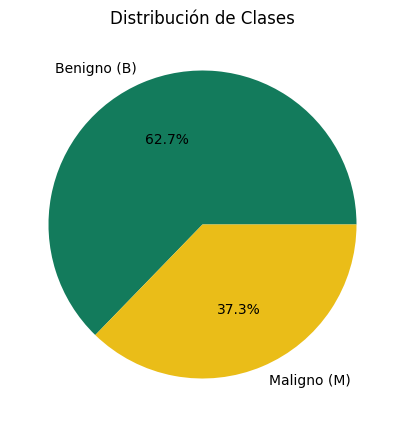

In [22]:
#Se cuentan cuantas ocurrencias hay por cada clase
class_count = cancer_df['target'].value_counts()

# Plot the pie chart
class_count.plot.pie(y='target', figsize=(5, 5), autopct='%1.1f%%', colors=['#137B5C', '#EABD18'], labels=['Benigno (B)', 'Maligno (M)'])
plt.title('Distribución de Clases')
plt.ylabel('')
plt.show()

Puede observarse claramente que existe un desequilibrio en el conjunto de datos favorable a la clase (B), esto puede generar problemas al momento de realizar predicciones sobre la clase (A) puesto que esta cuenta con una menor representación dentro del conjunto de datos.

Antes de comenzar a trabajar con el modelo, vamos a preparar nuestro conjunto de datos para ser utilizados por el mismo, para esto vamos a separar la columna "target" de las demás, de esa forma se podrán usar estos valores como etiquetas de cada una de las columnas. Para eso se realiza lo siguiente:

In [7]:
#División de los datos
X = cancer_df.drop(['target'], axis=1)
y = cancer_df['target']

A continuación, vamos a definir los conjuntos de entrenamiento y prueba, la proporción que usaremos para está separación será de un 70% datos de entrenamiento y un 30% datos para prueba.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, stratify=y)

Por último, debemos normalizar nuestros conjuntos de datos.

In [9]:
# Normalización de los datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Cantidad de datos de entrenamiento: {X_train.shape[0]}")
print(f"Cantidad de datos de prueba: {X_test.shape[0]}")

Cantidad de datos de entrenamiento: 398
Cantidad de datos de prueba: 171


## Regresión Logística

---

Para asignar una clase a un tumor, dadas sus características, haremos uso del modelo [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

### 1. Import

Primero debemos importar el modelo, junto con las librerías necesarias para entrenarlo y también para evaluar su rendimiento.

In [10]:
#Import del modelo
from sklearn.linear_model import LogisticRegression

#Entrenamiento
from sklearn.model_selection import GridSearchCV

#Evaluación
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score

### 2. Métricas

Antes de entrenar el modelo, debemos ajustar sus hiperparámetros para modificar su comportamiento y obtener el mejor rendimiento posible del mismo. En el caso de Regresión Logística, los hiperparámetros que debemos ajustar son los siguientes:

* C: Establece la fuerza de regularización que se ejerce sobre los coeficientes de nuestro modelo.
* penalty: Define que tipo de regularización se aplica al modelo.
* solver: Especifica el algoritmo utilizado para optimizar la función de pérdida.
* max_iter: Establece el máximo de iteraciones realizadas por el solver para converger.

In [11]:
# Colección de hiperparámetros que vamos a estimar
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

Para el entrenamiento del modelo se hará uso de validación cruzada mediante [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Es importante recordar que la validación cruzada consiste en dividir los datos definidos para entrenamientos en K grupos, luego utilizar K-1 grupos para entrenar el modelo y el grupo restante para validar, posteriormente se repite este proceso hasta que todo el conjunto de datos haya sido usado para validación.

Gracias a este proceso, nuestro modelo puede generalizar bien sobre datos que no son conocidos.

In [12]:
#Se procede a entrenar al modelo
grid_search = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='accuracy')

#Be quiet... Machine is Learning
grid_search.fit(X_train, y_train)

#Resultados
print(f"Mejores hiperparámetros: {grid_search.best_params_}")
print(f"Mejor puntuación de validación cruzada: {grid_search.best_score_ * 100:.2f}%")

Mejores hiperparámetros: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Mejor puntuación de validación cruzada: 98.24%


### 3. Pruebas

Una vez finalizado el ajuste de hiperparámetros, se almacena el modelo con mejor rendimiento obtenido:

In [13]:
#Se guarda el modelo obtenido de GridSearchCV
model_RL = grid_search.best_estimator_

Posteriormente se realizan predicciones sobre el conjunto de datos de prueba para así evaluar el rendimiento del modelo haciendo uso de las siguientes métricas:
* Accuracy: También llamado precisión o exactitud, representa el porcentaje de predicciones acertadas.
* Precision: Representa la proporción de predicciones positivas acertadas entre el total de predicciones positivas.
* Recall: Conocido también como exhaustividad, mide la proporción de predicciones positivas identificadas, ya sean verdaderos positivos o falsos negativos.
* F1 Score: Es la media armónica entre Precision y Recall, es una medida útil cuando no se esta seguro de que todas las clases tengan la misma cantidad de elementos.
* Matriz de Confusión: Muestra el número de predicciones correctas e incorrectas del modelo, comparándolas con los valores reales.
* Curva ROC: Nos muestra la relación entre el Recall (verdaderos positivos) y los falsos positivos para las diferentes clases. También representa la capacidad del modelo para discernir entre una clase u otra a medida que varía el umbral de clasificación.
* El AUC, es el área bajo la curva ROC, evalúa la capacidad del modelo para distinguir entre las dos clases.


In [14]:
#Primeras pruebas con el modelo
start_time = time.time()
y_pred = model_RL.predict(X_test)
end_time = time.time()

#Probabilidad de pertenecer a la clase positiva
y_pred_proba = model_RL.predict_proba(X_test)[:, 1]

### 4. Resultados obtenidos

En esta sección se muestran los valores obtenidos para algunas de las métricas antes mencionadas. Primero se muestra el tiempo de predicción obtenido:

In [15]:
#Tiempo de predicción
prediction_time = end_time - start_time
print(f"Tiempo de predicción: {prediction_time:.5f} segundos")

Tiempo de predicción: 0.00042 segundos


Luego podemos ver el puntaje obtenido de Accuracy y también el F1 Score:

In [16]:
print(f"Exactitud: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"F1 Score: {f1_score(y_test, y_pred) * 100:.2f}%")

Exactitud: 98.83%
F1 Score: 99.06%


Además se muestra la matriz de confusión asociada a la predicción:

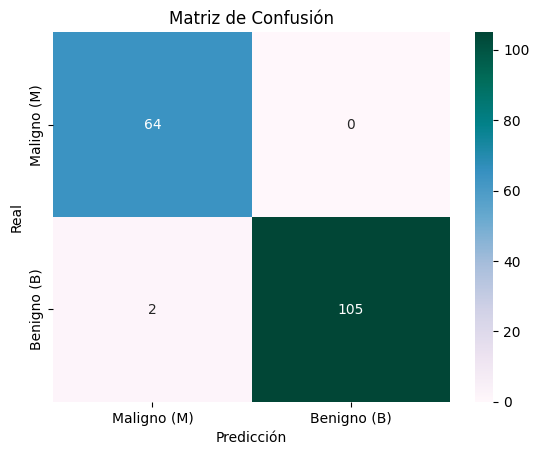

In [17]:
#Matrix de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='PuBuGn', xticklabels=['Maligno (M)', 'Benigno (B)'], yticklabels=['Maligno (M)', 'Benigno (B)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

También se muestra la curva ROC junto al correspondiente valor de AUC:

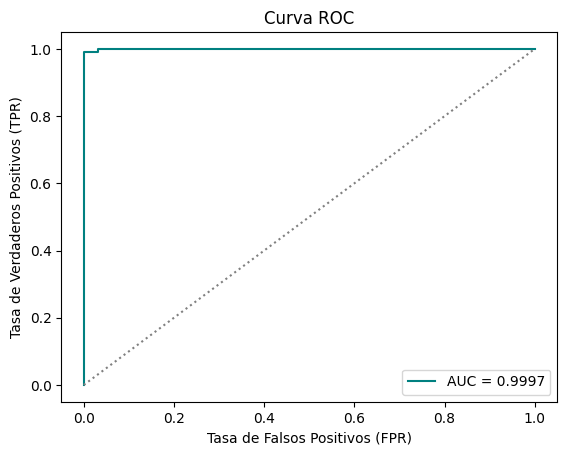

In [18]:
#Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

#Visualización
plt.plot(fpr, tpr, color='teal', label=f'AUC = {auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='dotted', color='gray')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()

## Preguntas finales

---

En esta sección se darán respuestas a las preguntas dejadas al final del enunciado correspondiente a la tarea 2.

### 1. Si tuviesen que seleccionar de un universo de N mujeres, k mujeres de tal manera que las mujeres representen los datos disponibles. Como harían?

### 2. El jefe de IT del hospital quisiera tener a la mano una implementacion del algoritmo de Curvas ROC y además de la metrica de área debajo de la curva.

Ver sección 4 dentro de Regresión Logística.

### 3. ¿Como afecta el balance de clases al modelo?

Se tiende a producir una preferencia hacia la clase mayoritaria, ya que, al tener más representación dentro del conjunto de datos, resulta más cómodo siempre asignar esta clase al momento de predecir de fomra que se maximice el accuracy. Sin embargo esto no es útil puesto que nos interesa que el modelo sea capaz de asignar correctamente en cualquiera de las 2 clases disponibles, no solo la mayoritaria.

Además de eso se genera una desventaja con respecto al aprendizaje para la clase minoritaria, ya que el modelo cuenta con menos oportunidades de aprender las características que la representan.

### 4. ¿Por qué es importante usar AUC y F1-Score además de la exactitud?

El AUC y F1 Score son de vital importancia ya que ofrecen una medición más completa acerca del comportamiento de nuestro modelo en comparación a la exactitud. Si bien es importante tener siempre en cuenta la exactitud, en casos como el actual, donde los datos tienen un desbalance notable, esta métrica pierde un poco de credibilidad.

Por ejemplo, si se tiene un conjunto de datos dividos en 2 clases y un 95% de los datos pertenecen a la clase A y el resto a la clase B, un modelo que sesgado hacía la clase A siempre tendrá una mayor exactitud, sin embargo no va a generalizar bien al momento de clasificar un nuevo dato.

El F1 Score nos da una visión mas equilibrada de como el modelo indetifica las instancias verdaderamente positivas y negativas dentro de un conjunto de datos.

Fl AUC, al igual que el F1 Score, nos permite tener una visión mas detallada de la clasificación realizada por nuestro modelo, ya que evalúa su capacidad para decidirse por una clase.